# Simulation 

In [1]:
import os
import sys
sys.path.append('..')
from sfp_nsdsyn import simulation as sim
from sfp_nsdsyn import two_dimensional_model as model
from sfp_nsdsyn import utils as utils
from sfp_nsdsyn.visualization import plot_2D_model_results as vis2D
from sfp_nsdsyn.cross_validation_2d_model import plot_model_comparison_params
from gsn.perform_gsn import perform_gsn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import json
config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [3]:
params = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/summary/precision_weighted_params.csv')
params = params.query('vroinames == "V1"')
params_dict = params.to_dict(orient='records')[0]

In [4]:
# load in actual subj data
subj_list = ['subj01']

roi='V1'
all_df = pd.DataFrame({})
for subj in subj_list:
    subj_data = pd.read_csv(config['OUTPUT_DIR'] + f'dataframes/nsdsyn/model/dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize_tavg-False.csv')
    subj_precision = pd.read_csv(config['OUTPUT_DIR'] + f'dataframes/nsdsyn/precision/precision-v_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    subj_data['trial'] = subj_data.groupby(['sub','voxel','class_idx']).cumcount()
    subj_data = subj_data.merge(subj_precision, on=['sub','voxel'])
    subj_data['normed_betas'] = model.normalize(subj_data, 'betas', ['sub','voxel'], phase_info=True)
    all_df = pd.concat([all_df, subj_data])

all_df.head()

,trial,image_idx,run,task,stim_idx,w_r,w_a,phase,class_idx,phase_idx,...,vroinames_x,eccrois,local_sf,local_ori,hemi,sub,vroinames_y,noise_SD,sigma_v_squared,normed_betas
0,0,105,7,memory,0,0.0,-6.0,0.000000,0,0,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.149929
1,1,105,2,fixation,0,0.0,-6.0,0.000000,0,0,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.048191
2,2,106,6,fixation,1,0.0,-6.0,1.570796,0,2,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.016159
3,3,106,3,memory,1,0.0,-6.0,1.570796,0,2,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.067219
4,4,107,1,memory,2,0.0,-6.0,3.141593,0,4,...,V1,3.0,0.613683,0.318386,lh,subj01,V1,0.982755,1.084998,0.035283


In [ ]:
syn = sim.SynthesizeData(roi='V1', df=subj_data)
scaled_sim_data = syn.synthesize_BOLD_2d(params_dict, 
                                    grating_type='scaled', 
                                    model=7, phase_info=True)

scaled_sim_data = syn.add_noise(scaled_sim_data, 'normed_betas', n_trials=8, noise_cov=subj_cov_matrix)
scaled_sim_data.head()

,sub,w_r,w_a,class_idx,names,freq_lvl,voxel,angle,eccentricity,noise_SD,sigma_v_squared,trial,local_sf,local_ori,betas,normed_betas,noise,noisy_normed_betas
0,subj01,0.0,-6.0,0,pinwheel,0,10,5.030775,1.556064,0.982755,1.084998,0,0.613683,0.318386,0.698175,0.055679,-0.036222,0.019458
1,subj01,0.0,-11.0,1,pinwheel,1,10,5.030775,1.556064,0.982755,1.084998,0,1.125085,0.318386,0.920265,0.073391,-0.036222,0.037169
2,subj01,0.0,-20.0,2,pinwheel,2,10,5.030775,1.556064,0.982755,1.084998,0,2.045609,0.318386,1.035053,0.082545,-0.036222,0.046324
3,subj01,0.0,-37.0,3,pinwheel,3,10,5.030775,1.556064,0.982755,1.084998,0,3.784377,0.318386,0.994868,0.079340,-0.036222,0.043119
4,subj01,0.0,-69.0,4,pinwheel,4,10,5.030775,1.556064,0.982755,1.084998,0,7.057351,0.318386,0.809529,0.064560,-0.036222,0.028338


In [114]:
syn = sim.SynthesizeData(roi='V1', n_voxels=1000, df=subj_data)
scaled_sim_data = syn.synthesize_BOLD_2d(params_dict, 
                                    grating_type='scaled', 
                                    model=7, phase_info=True)

scaled_sim_data = syn.add_noise(scaled_sim_data, 'normed_betas', n_trials=8, noise_cov=subj_cov_matrix)

In [115]:
constant_sim_data = syn.synthesize_BOLD_2d(params_dict, 
                                      grating_type='constant', 
                                      model=7, phase_info=True)
constant_sim_data = syn.add_noise(constant_sim_data, 'normed_betas', n_trials=8, noise_cov=subj_cov_matrix)


In [118]:
scaled_sim_data = scaled_sim_data.groupby(['sub','voxel','class_idx']).mean().reset_index()
my_dataset = model.SpatialFrequencyDataset(scaled_sim_data, beta_col='noisy_normed_betas')
my_model = model.SpatialFrequencyModel(random_state=42)

scaled_loss_history, scaled_model_history, scaled_losses = model.fit_model(my_model, my_dataset,
                                                                            save_path=None,
                                                                            learning_rate=0.0005, max_epoch=20000,
                                                                            print_every=1000, loss_all_voxels=False)

**epoch no.0 loss: 0.0560086604
**epoch no.999 loss: 0.0082636871
**epoch no.1999 loss: 0.0021550893
**epoch no.2999 loss: 0.0008906038
**epoch no.3999 loss: 0.0003966618
**epoch no.4999 loss: 0.0001805731
**epoch no.5999 loss: 8.696e-05
**epoch no.6999 loss: 5.04616e-05
**epoch no.7999 loss: 3.92752e-05
**epoch no.8999 loss: 3.71271e-05
**epoch no.9999 loss: 3.69525e-05
**epoch no.10999 loss: 3.69494e-05
**epoch no.11999 loss: 3.69494e-05
**epoch no.12999 loss: 3.69494e-05
**epoch no.13999 loss: 3.69494e-05
**epoch no.14999 loss: 3.69494e-05
**epoch no.15999 loss: 3.69494e-05
**epoch no.16999 loss: 3.69494e-05
**epoch no.17999 loss: 3.69494e-05
**epoch no.18999 loss: 3.69494e-05
**epoch no.19999 loss: 3.69494e-05
*epoch no.20000: Finished! final model params...
 {'sigma': 2.24, 'slope': 0.15, 'intercept': 0.17, 'p_1': 0.08, 'p_2': -0.02, 'p_3': -0.04, 'p_4': -0.07, 'A_1': 0.06, 'A_2': -0.02}
Elapsed time: 168.36 sec


In [119]:
constant_sim_data = constant_sim_data.groupby(['sub','voxel','class_idx']).mean().reset_index()
my_dataset = model.SpatialFrequencyDataset(constant_sim_data, beta_col='noisy_normed_betas')
my_model = model.SpatialFrequencyModel(random_state=42)

constant_loss_history, constant_model_history, constant_losses = model.fit_model(my_model, my_dataset,
                                                                            save_path=None,
                                                                            learning_rate=0.0005, max_epoch=20000,
                                                                            print_every=1000, loss_all_voxels=False)

**epoch no.0 loss: 0.0463360959
**epoch no.999 loss: 0.0254442645
**epoch no.1999 loss: 0.0017021413
**epoch no.2999 loss: 0.0007676127
**epoch no.3999 loss: 0.0003782856
**epoch no.4999 loss: 0.0001988426
**epoch no.5999 loss: 0.0001184268
**epoch no.6999 loss: 8.62063e-05
**epoch no.7999 loss: 7.60235e-05
**epoch no.8999 loss: 7.39773e-05
**epoch no.9999 loss: 7.37979e-05
**epoch no.10999 loss: 7.37942e-05
**epoch no.11999 loss: 7.37942e-05
**epoch no.12999 loss: 7.37942e-05
**epoch no.13999 loss: 7.37942e-05
**epoch no.14999 loss: 7.37942e-05
**epoch no.15999 loss: 7.37942e-05
**epoch no.16999 loss: 7.37942e-05
**epoch no.17999 loss: 7.37942e-05
**epoch no.18999 loss: 7.37942e-05
**epoch no.19999 loss: 7.37942e-05
*epoch no.20000: Finished! final model params...
 {'sigma': 2.24, 'slope': 0.16, 'intercept': 0.16, 'p_1': 0.08, 'p_2': -0.02, 'p_3': -0.04, 'p_4': -0.07, 'A_1': 0.06, 'A_2': -0.02}
Elapsed time: 173.49 sec


In [15]:
noise_1_df = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/simulation/roi-V1_grating-scaled_cov-True_noise-1_basesub-subj01.csv')
noise_7_df = pd.read_csv('/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/simulation/roi-V1_grating-scaled_cov-True_noise-7_basesub-subj01.csv')


In [22]:
noise_1_df = noise_1_df.query('voxel == 10 & class_idx == 0')[['voxel','class_idx','trial','normed_betas','noise','noisy_normed_betas']]

In [23]:
noise_1_df

,voxel,class_idx,trial,normed_betas,noise,noisy_normed_betas
0,10,0,0,0.055679,-0.036222,0.019458
28,10,0,1,0.055679,-0.009174,0.046505
56,10,0,2,0.055679,-0.007799,0.047880
84,10,0,3,0.055679,0.025268,0.080948
112,10,0,4,0.055679,0.074779,0.130458
140,10,0,5,0.055679,-0.050943,0.004737
168,10,0,6,0.055679,-0.010722,0.044957
196,10,0,7,0.055679,0.012447,0.068126


In [24]:
noise_1_df.groupby(['voxel','class_idx']).mean()

,,trial,normed_betas,noise,noisy_normed_betas
voxel,class_idx,,,,
10,0,3.5,0.055679,-0.000296,0.055384


In [25]:
noise_7_df = noise_7_df.query('voxel == 10 & class_idx == 0')[['voxel','class_idx','trial','normed_betas','noise','noisy_normed_betas']]
noise_7_df

,voxel,class_idx,trial,normed_betas,noise,noisy_normed_betas
0,10,0,0,0.055679,-0.253552,-0.197872
28,10,0,1,0.055679,-0.064221,-0.008542
56,10,0,2,0.055679,-0.054596,0.001084
84,10,0,3,0.055679,0.176878,0.232558
112,10,0,4,0.055679,0.523452,0.579132
140,10,0,5,0.055679,-0.356598,-0.300918
168,10,0,6,0.055679,-0.075053,-0.019374
196,10,0,7,0.055679,0.087126,0.142805


In [26]:
noise_7_df.groupby(['voxel','class_idx']).mean()

,,trial,normed_betas,noise,noisy_normed_betas
voxel,class_idx,,,,
10,0,3.5,0.055679,-0.00207,0.053609


In [238]:
lr=0.0005
max_epoch=30000
subj='subj01'
grating_types = ['scaled', 'constant']
noise_levels = [1,3,5,7,10]
noise_mapping = {'1': 'low', '7': 'high'}
noise_levels = [1,7]
pt_file_list = []
for grating, noise_lvl in itertools.product(grating_types, noise_levels):
    file_name = f'model-params_roi-V1_grating-{grating}_cov-True_noise-{noise_lvl}_lr-{lr}_eph-{max_epoch}_basesub-{subj}.pt'
    print(file_name)
    pt_file_list.append(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/simulation/' + file_name)
model_df = model.load_all_models(pt_file_list, *['grating', 'noise'])

model_df['noise'] = model_df['noise'].map(noise_mapping)
model_df['grating'] = model_df['grating'].map({'scaled': 'scaled', 'constant': 'uniform'})



model-params_roi-V1_grating-scaled_cov-True_noise-1_lr-0.0005_eph-30000_basesub-subj01.pt
model-params_roi-V1_grating-scaled_cov-True_noise-7_lr-0.0005_eph-30000_basesub-subj01.pt
model-params_roi-V1_grating-constant_cov-True_noise-1_lr-0.0005_eph-30000_basesub-subj01.pt
model-params_roi-V1_grating-constant_cov-True_noise-7_lr-0.0005_eph-30000_basesub-subj01.pt


In [242]:
noise_7_df['noise']

0        -0.253552
1        -0.253552
2        -0.253552
3        -0.253552
4        -0.253552
            ...   
516763    0.233611
516764    0.233611
516765    0.233611
516766    0.233611
516767    0.233611
Name: noise, Length: 516768, dtype: float64

In [237]:
model_df

,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,grating,noise
0,2.199300,0.150470,0.171367,0.080991,-0.021897,-0.036557,-0.06593,0.057589,-0.019375,scaled,low
0,2.199300,0.150470,0.171367,0.080991,-0.021897,-0.036557,-0.06593,0.057589,-0.019375,scaled,high
0,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.06593,0.057589,-0.019376,uniform,low
0,2.199299,0.150471,0.171367,0.080991,-0.021897,-0.036557,-0.06593,0.057589,-0.019376,uniform,high


(<Figure size 1728x540 with 9 Axes>,
 array([<AxesSubplot:ylabel='Parameter estimates'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

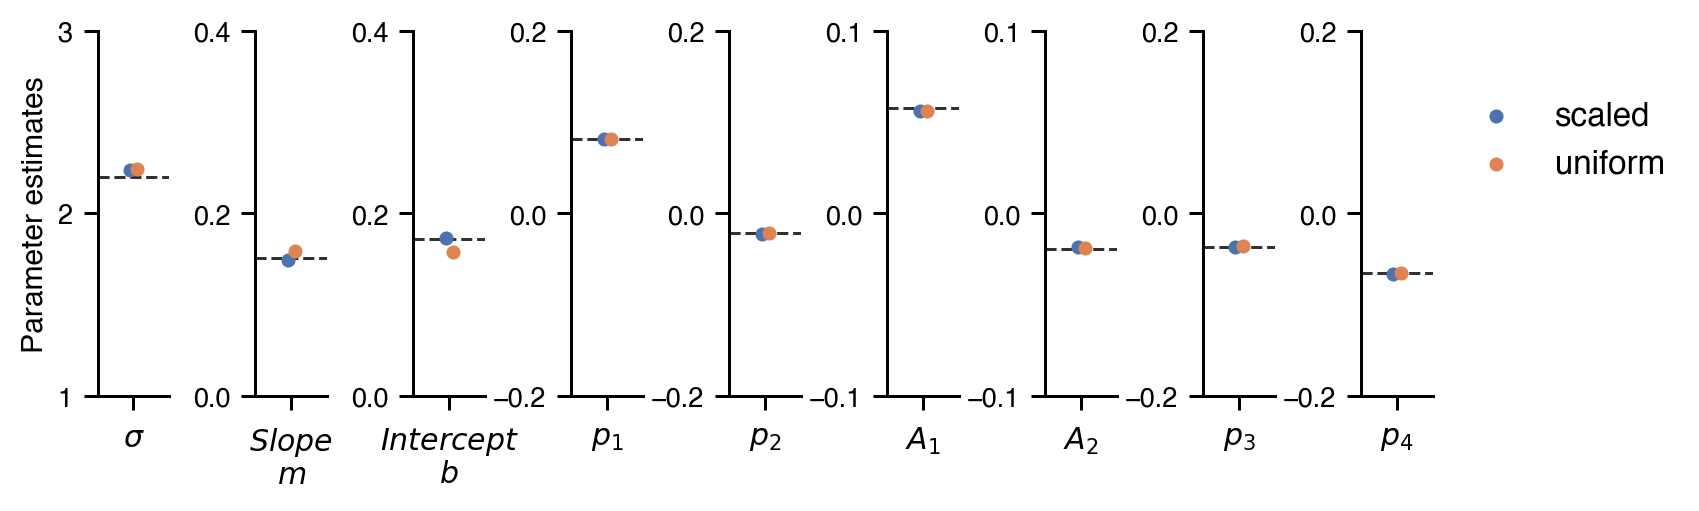

In [ ]:
params_list = ['sigma', 'slope', 'intercept', 'p_1', 'p_2', 'A_1','A_2','p_3', 'p_4']
params_vals = params[params_list].iloc[0].tolist()
# Plug in the values directly to the color map
color_map = [
    (31, 119, 180),  # blue for 'scaled'
    (174, 199, 232),  # light blue for 'scaled'
    (255, 127, 14),  # orange for 'constant'
    (255, 187, 120)  # light orange for 'constant'
]
color_map = [(r/255, g/255, b/255) for r, g, b in color_map]


ylim_list = [(1, 3), (0, 0.4),(0, 0.4), (-0.2, 0.2), (-0.2, 0.2),(-0.1,0.1),(-0.1,0.1), (-0.2, 0.2), (-0.2, 0.2)]
yticks_list=  [[1,2,3], [0, 0.2, 0.4], [0, 0.2, 0.4], [-0.2,0,0.2], [-0.2,0,0.2], [-0.1,0,0.1], [-0.1,0,0.1], [-0.2,0,0.2], [-0.2,0,0.2]]
vis2D.plot_simulation_results(model_df, params_list, ground_truth=params_vals, 
                              hue='grating', ylim=ylim_list, yticks=yticks_list, scale=0.8,
                              **{'palette': color_map, 'hue_order': ['scaled - low', 'scaled - high', 'constant - low', 'constant - high']})

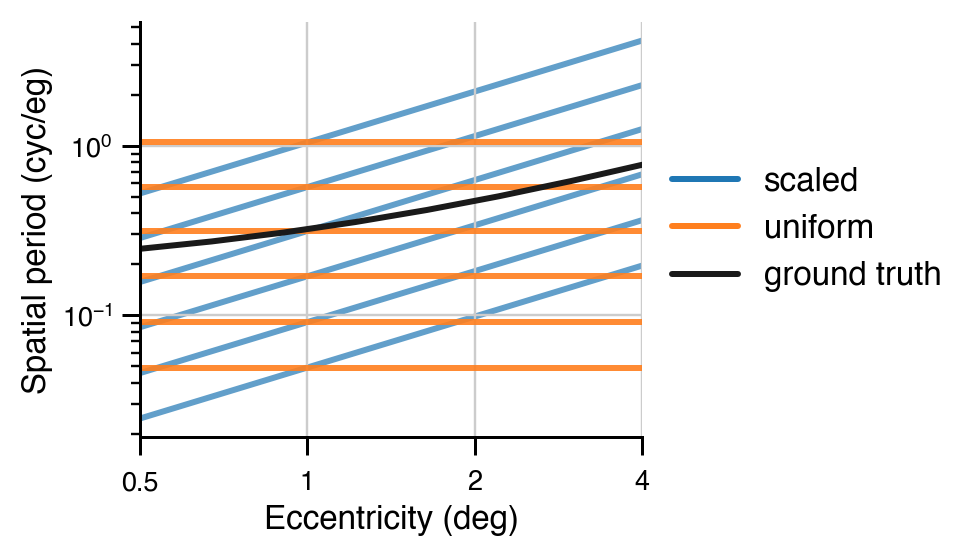

In [ ]:
# Example usage
base_sfs = np.array([6, 11, 20, 37, 69, 128])  # shape (6,)
eccen = np.logspace(np.log10(0.5), np.log10(4), 8)  # shape (8,)


save_path = config['OUTPUT_DIR'] + 'figures/simulation/simulation_design.svg'
vis2D.plot_simulation_design(base_sfs, 
                             eccen, 
                             slope=params['slope'].iloc[0], 
                             intercept=params['intercept'].iloc[0],
                             save_path=save_path)


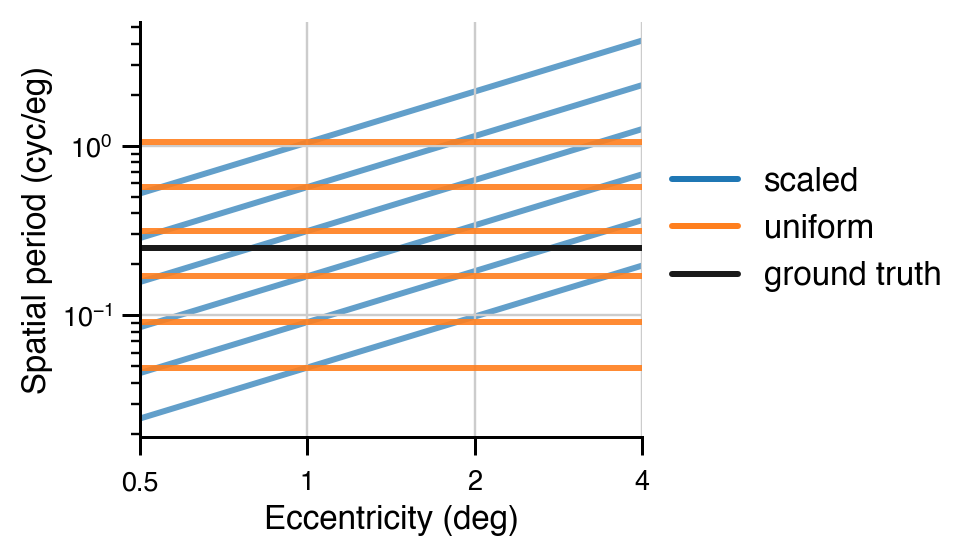

In [58]:
new_params = params.copy()
new_params['slope'] = 0
new_params['p_1'] = 0
new_params['p_2'] = 0
new_params['p_3'] = 0
new_params['p_4'] = 0
new_params['intercept'] = 0.25
save_path = config['OUTPUT_DIR'] + 'figures/simulation/simulation_design_slopezero.svg'

vis2D.plot_simulation_design(base_sfs, 
                             eccen, 
                             slope=new_params['slope'].iloc[0], 
                             intercept=new_params['intercept'].iloc[0],
                             save_path=save_path)


In [ ]:
new_params = params.copy()
new_params['slope'] = 0
new_params['p_1'] = 0
new_params['p_2'] = 0
new_params['p_3'] = 0
new_params['p_4'] = 0
new_params['intercept'] = 0.25